## STEP1: Data Reading and understanding 

In [1043]:
# import the libraries required for the sheet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Suppressing warnings 
import warnings
warnings.filterwarnings("ignore")

In [1044]:
# Import and read the dataset
df = pd.read_csv(r'D:\Courses\Upgrad\5.ML-1\6.Clustering Assignment\Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [1045]:
# looking at the shape of dataset
df.shape

(167, 10)

In [1046]:
# Check the column wise info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [1047]:
# Get the summary of the dataframe using 'describe()'
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Step 2: Preparing the data

For the assignment we must convert certain values to their absolute form, like exports, health and imports.<br>

Currently they are in present as percentage of GDP per capita <br>

<b>NOTE:-</b> In the data dictionary the above 3 features are mentioned as %age of GDP per capita<br>
Thus, if we assume GDP per capita as 100 for any country we can assume their respective features as their respective absolute values, thus substituting this our formula becomes:<br>

<b>Absolute Value of the feature(x) = GDPP * precentage value of GDPP of the feature(y) / 100</b><br>

In [1049]:
# Get the duplicates values
df.loc[df.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp



<b>No duplicate values in the dataset</b>

In [1050]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

<b>We do not have any missing value in the dataset</b>

In [1051]:
# converting the percentage values of the feature columns to their absolute values
df['exports'] = df['exports'] * df['gdpp']/100
df['imports'] = df['imports']* df['gdpp']/100
df['health'] = df['health'] * df['gdpp']/100
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [1052]:
# looking at the generative statistics of the data
df.describe(percentiles=[.25,.5,.75,.9,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


In [1053]:
# Checking if the counts of countries is unique

if(len(df.country.unique()) == len(df.country)):
    print("True")
else:
    print("False")

True


## Step 3. Exploratory Data Analysis

### Univariate Analysis

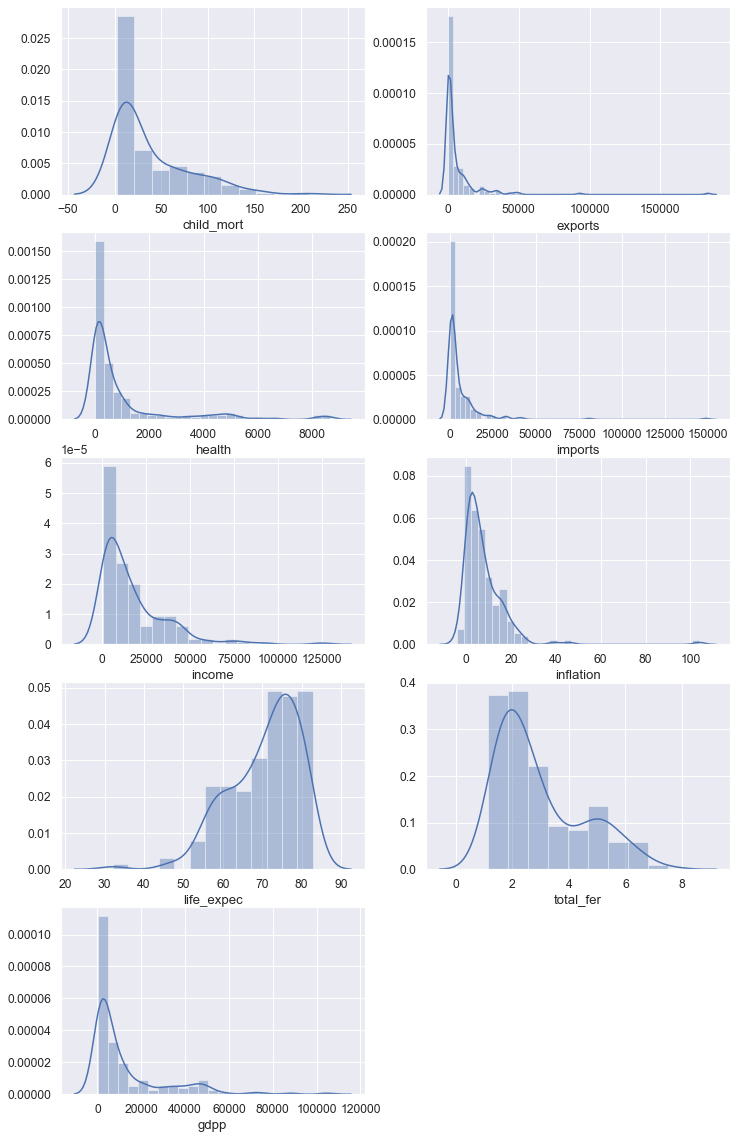

In [1054]:
plt.figure(figsize=(12,20))
sns.set(font_scale = 1.1)
cols = df.columns[1:]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.distplot(df[i[1]])
plt.show()

Inference :

All the variables are not Normally distributed<br>
Most of the variables are Positively skewd like child_mort, exports, health, income, total_fer, gdpp.<br>
The variables are Negatively skewd is life_expec

### Finding Outliers

Here we try to finding any outliers are present or not.<br>
We need to treat the outliers in proper way because as we are going to implement Clustering algorithm, so that outliers can be a major issue

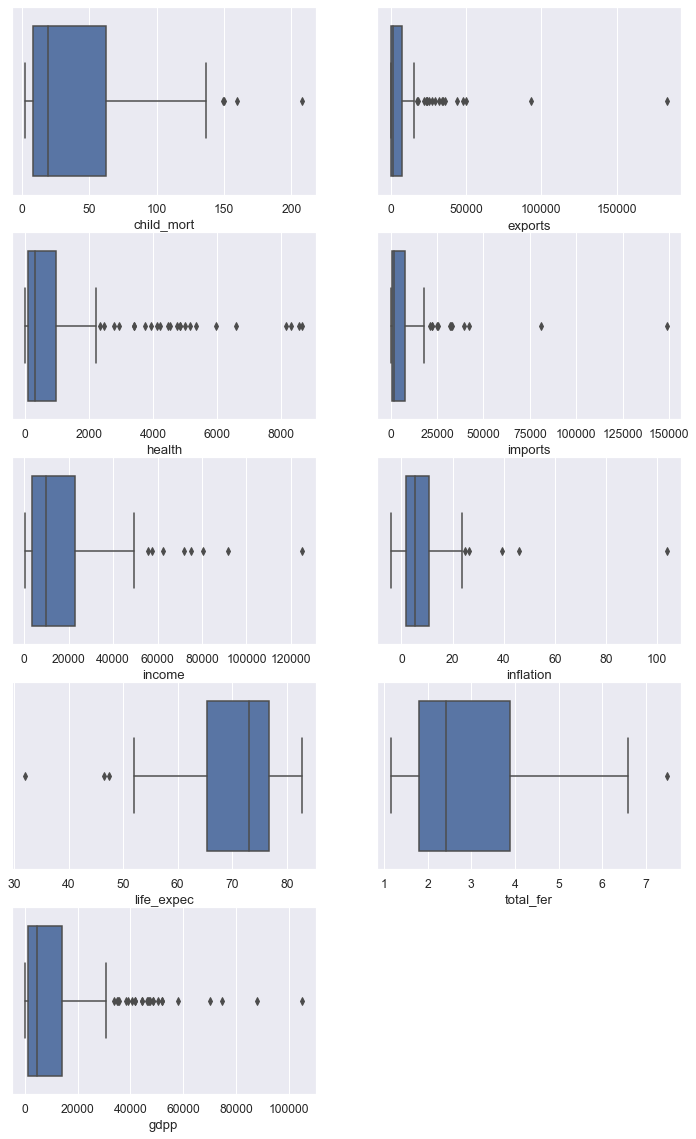

In [1055]:
# Here we use boxplot for finding the outliers
plt.figure(figsize = (12,20))
cols = df.columns[1:]
for i in enumerate(cols):
    plt.subplot(5,2, i[0]+1)
    sns.boxplot(df[i[1]])
plt.show()

### Bivariate Analysis:

Visualizing numeric variables

<Figure size 1440x1080 with 0 Axes>

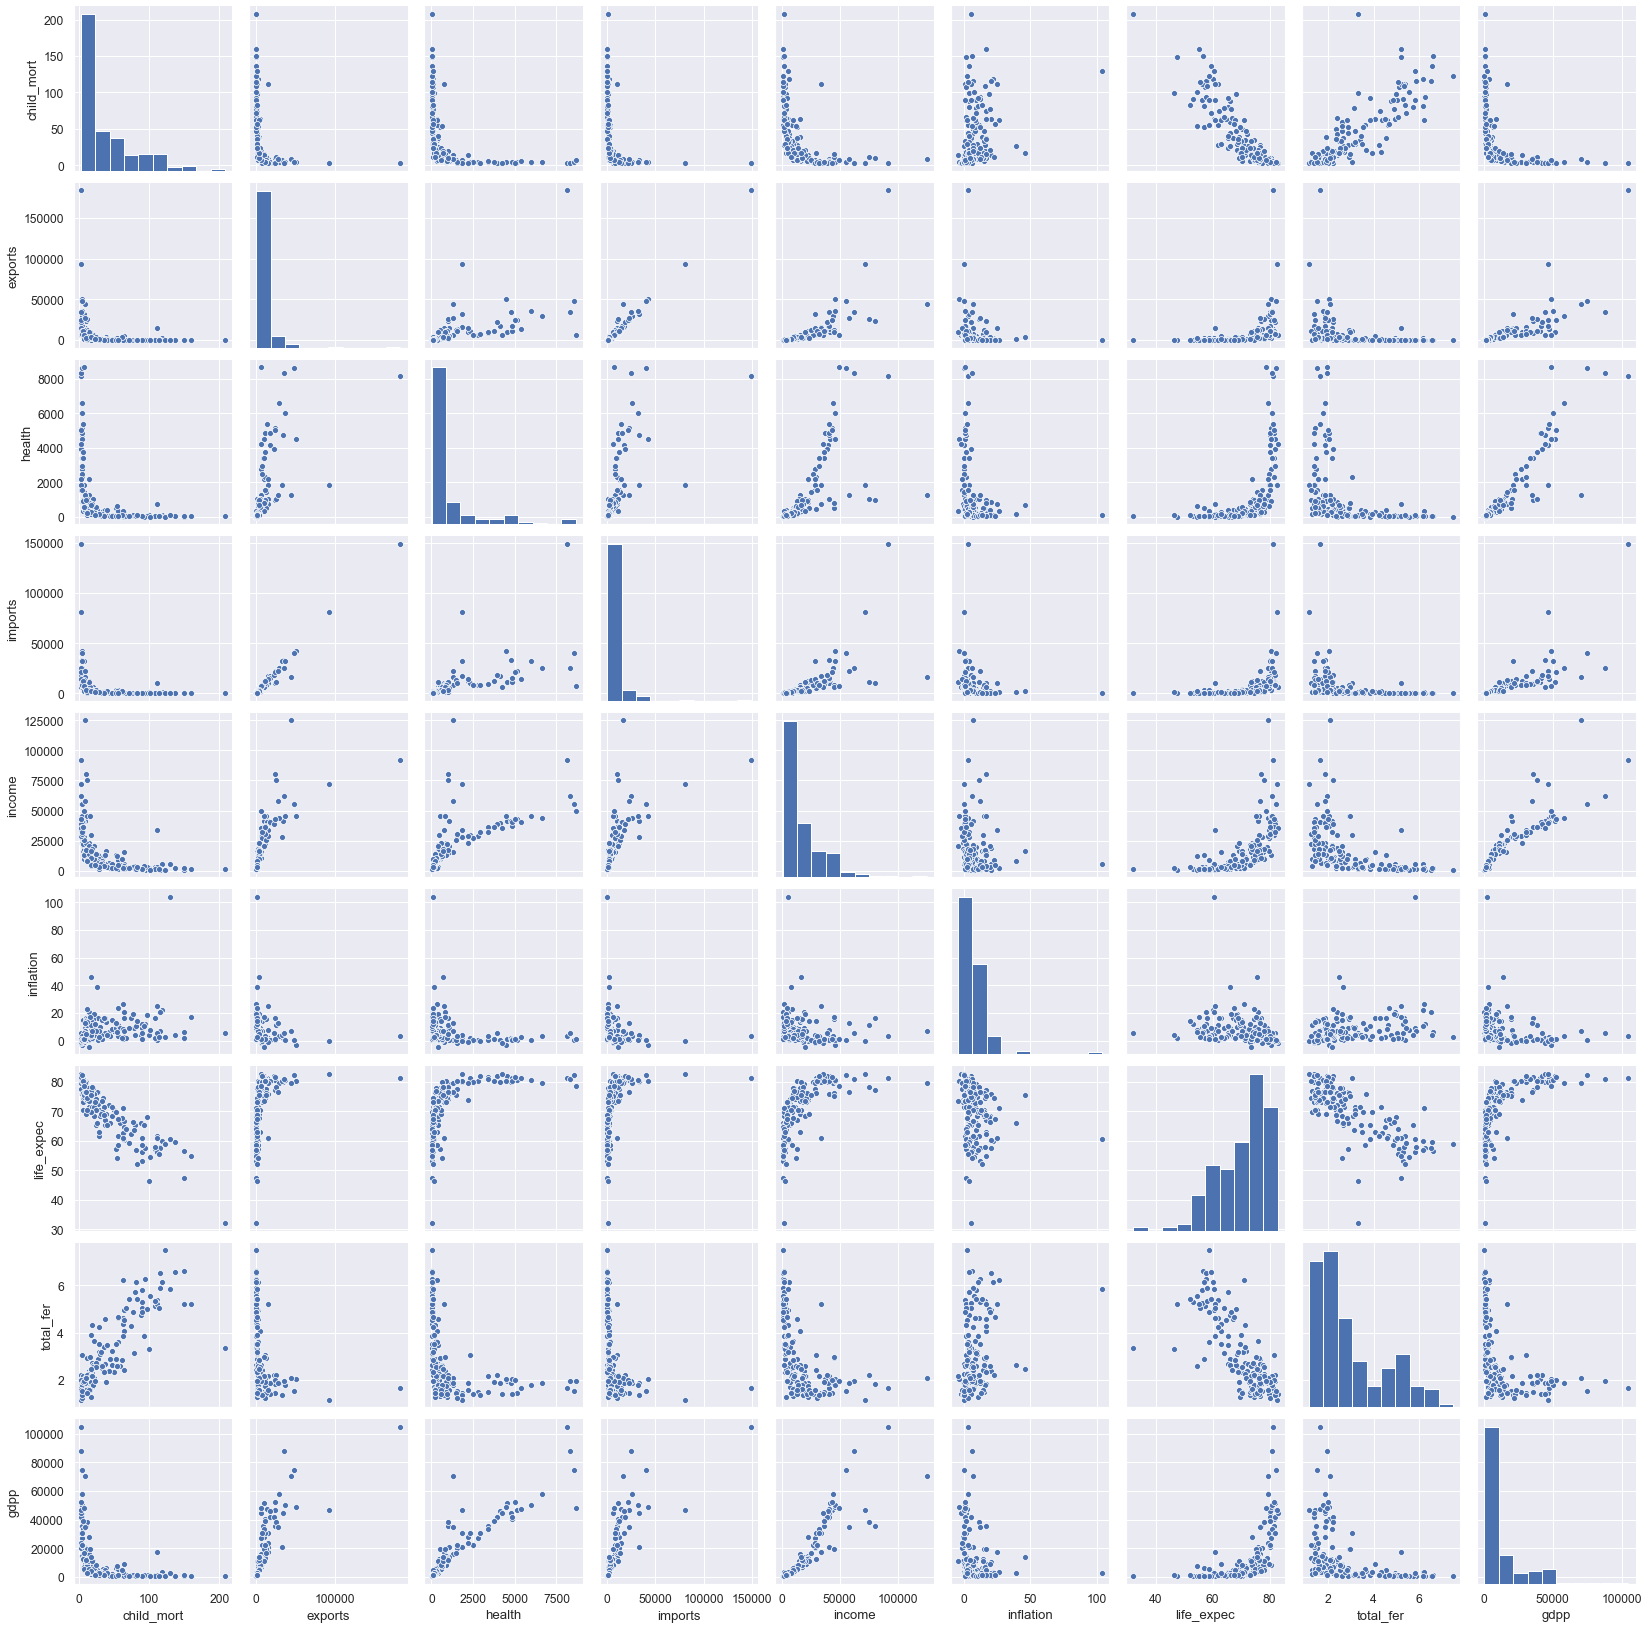

In [1056]:
# Creating a pairplot for the data set 
plt.figure(figsize=(20,15))
sns.pairplot(df, kind='scatter')
plt.show()

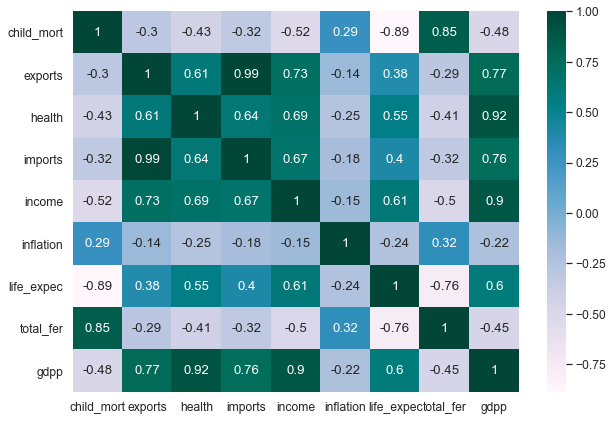

In [1057]:
# lets create a heatmap of the correlation of the dataset
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot = True, cmap = "PuBuGn")
plt.show()

 ## Step 4. Prepare the data for modelling

In [1058]:
# Before manipulating data, we will save one copy of orignal data.
country_help = df.copy()
country_help.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Outlier Treatment: Capping

There are a lot of outliers in our features, however due to limited data we cannot drop the rows, thus now we need to perform capping to all of our features as per the following<br>

For all columns except "child_mort" and "total_fer" we will perform capping on the upper range, because we do not wish to loose critical information about the countries that are in need of help.<br>

For "child_mort" and "total_fer" we will treat the lower range of outliers

In [1059]:
# decalaring the quantiles at which we will cap the values.
q1 = df['child_mort'].quantile(0.01)
q2 = df['exports'].quantile(0.99)
q3 = df['health'].quantile(0.99)
q4 = df['imports'].quantile(0.99)
q5 = df['income'].quantile(0.99)
q6 = df['inflation'].quantile(0.99)
q7 = df['life_expec'].quantile(0.99)
q8 = df['total_fer'].quantile(0.01)
q9 = df['gdpp'].quantile(0.99)

#performing capping
df['child_mort'][df['child_mort']<= q1] = q1
df['exports'][df['exports']>= q2] = q2
df['health'][df['health']>= q3] = q3
df['imports'][df['imports']>= q4] = q4
df['income'][df['income']>= q5] = q5
df['inflation'][df['inflation']>= q6] = q6
df['life_expec'][df['life_expec']>= q7] = q7
df['total_fer'][df['total_fer']<= q8] = q8
df['gdpp'][df['gdpp']>= q9] = q9

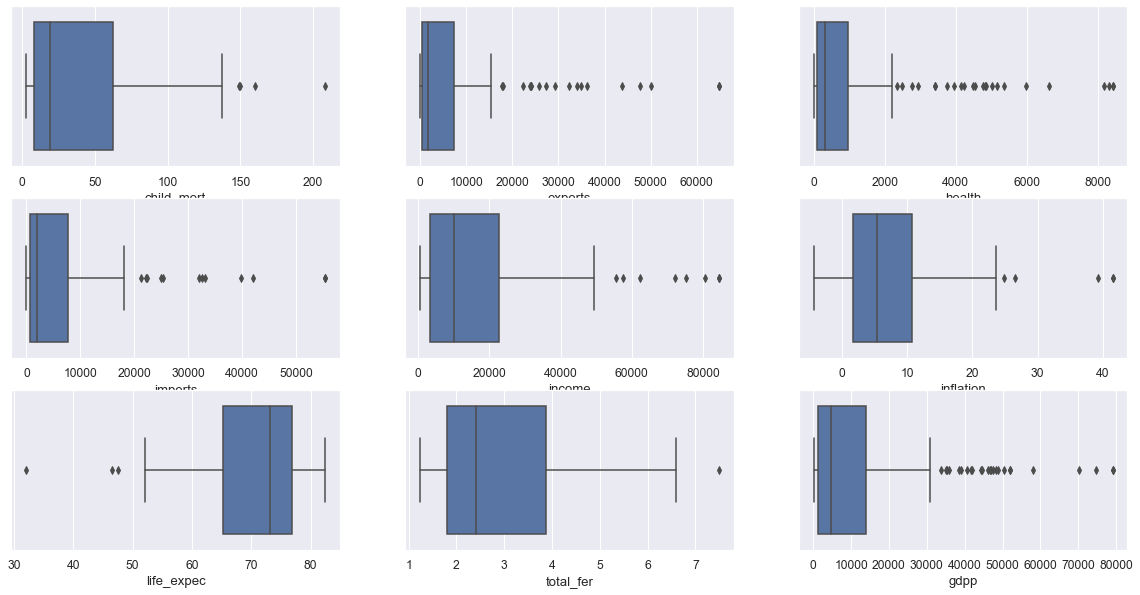

In [1060]:
# Visualizing all features as a box plot to check the outliers again
plt.figure(figsize = (20,10))
feature = df.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(df[i[1]])

In [1061]:
# looking at the generative statistics of the data again
df.describe(percentiles=[.25,.5,.75,.9,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.271257,6538.214776,1054.206622,5873.135222,16857.550898,7.380970,70.551138,2.948601,12756.826347
std,40.327869,11415.308590,1790.845342,9422.700869,17957.012855,7.793224,8.886987,1.513108,17430.208938
min,2.800000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.243200,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,55136.308400,8352.982736,46629.102600,81883.160000,39.974520,82.257800,6.563600,76125.920000


## Step 5: Cluster tendency Check

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.<br>
<ul>
<li>If the value is between {0.01, ...,0.3}, the data is regularly spaced.</li>
<li>If the value is around 0.5, it is random.</li>
<li>If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.</li>
<ul>

In [1062]:
# The code for the hopkins statistic have been copied from the file that was within the clusterting module

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [1063]:
# Checking the Hopkins statistics on the dataset
round(100*(hopkins(df.drop('country', axis = 1))))

88.0

<b>Such high value of hopskin statistic depicts high tendency to form clusters.</b>

#### Feature Scaling

In [1064]:
#Perform scaling
ss = StandardScaler()
scaled_df = ss.fit_transform(df.drop('country', axis = 1))
scaled_df

array([[ 1.29153663, -0.56962212, -0.56695778, ..., -1.61970522,
         1.90339023, -0.70225949],
       [-0.53899289, -0.47385792, -0.4403934 , ...,  0.64883094,
        -0.86081558, -0.49872564],
       [-0.27286971, -0.42399973, -0.48627082, ...,  0.67140344,
        -0.03884551, -0.47743428],
       ...,
       [-0.37235501, -0.49160668, -0.54024972, ...,  0.28767096,
        -0.66195186, -0.65869853],
       [ 0.44839871, -0.53995007, -0.55242911, ..., -0.34435902,
         1.14107928, -0.65869853],
       [ 1.11495022, -0.52701632, -0.54227159, ..., -2.09372771,
         1.62498101, -0.6500669 ]])

In [1065]:
scaled_df= pd.DataFrame(scaled_df)
scaled_df.columns= df.columns[1:]
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.569622,-0.566958,-0.598741,-0.851668,0.265002,-1.619705,1.903390,-0.702259
1,-0.538993,-0.473858,-0.440393,-0.413584,-0.386946,-0.372075,0.648831,-0.860816,-0.498726
2,-0.272870,-0.424000,-0.486271,-0.476100,-0.221053,1.122161,0.671403,-0.038846,-0.477434
3,2.007831,-0.381249,-0.534088,-0.463973,-0.612045,1.932987,-1.179541,2.128769,-0.530950
4,-0.695682,-0.086742,-0.178410,0.139728,0.125254,-0.764618,0.705262,-0.542634,-0.032042


## Step 6: Modeling using KMeans

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$
$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of<br>

$q$ is the mean intra-cluster distance to all the points in its own cluster.<br>

The value of the silhouette score range lies between -1 to 1.<br>

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

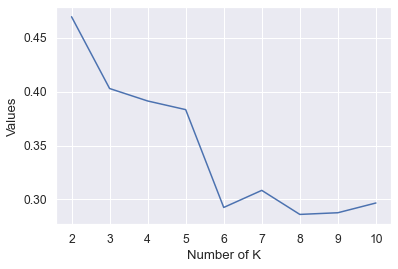

In [1066]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k).fit(scaled_df)
    ss.append([k, silhouette_score(scaled_df, kmeans.labels_)])

sil = pd.DataFrame(ss)    
plt.plot(sil[0], sil[1])
plt.xlabel('Number of K')
plt.ylabel('Values')
plt.show()

Scores for different k values can be seen above. It says k=2 is the best choice.<br>
Choosing k=3,because we are doing clustering and we do not wish to divide the graph into 2 by usking K=2<br>

In order to make the conclusion more robust, let's do SSD as well.

### SSD

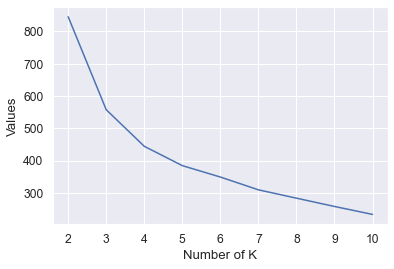

In [1067]:
#Elbow Curve

ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(scaled_df)
    ssd.append([k, kmean.inertia_])
    
ssd = pd.DataFrame(ssd)
plt.plot(ssd[0], ssd[1])
plt.xlabel('Number of K')
plt.ylabel('Values')
plt.show()

Elbow is formed as k=3 in the above curve as we can see that there is high slope till 3.

In [1068]:
#Model with k =3

kmean = KMeans(random_state = 0, n_clusters = 3 )
kmean.fit(scaled_df)

KMeans(n_clusters=3, random_state=0)

In [1069]:
# checking the labels
kmean.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [1070]:
# assign the labels to the dataset
df['cluster_id'] = kmean.labels_
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


In [1071]:
# Cluster counts
df.cluster_id.value_counts()

1    90
0    48
2    29
Name: cluster_id, dtype: int64

## Step 7: Cluster Profiling of clusters formed by KMeans

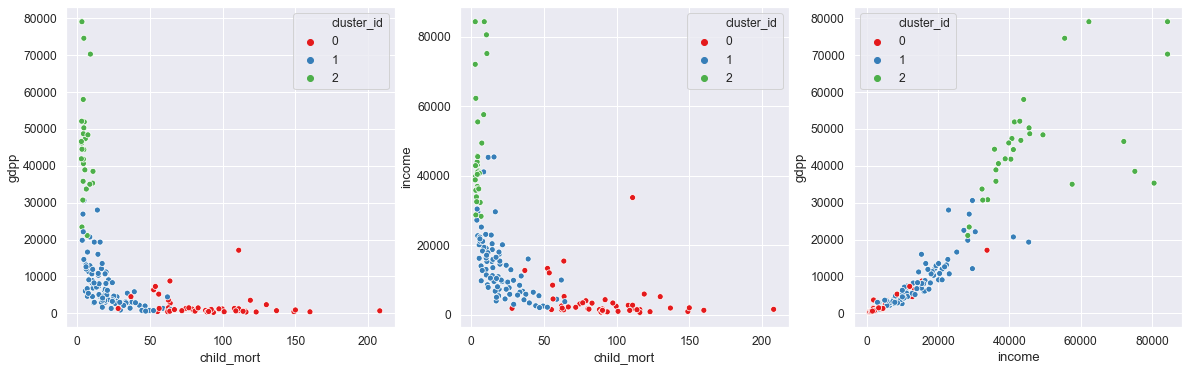

In [1072]:
plt.figure(figsize=(20,20))
plt.subplot(331)
sns.scatterplot(x = "child_mort" , y = "gdpp", hue = 'cluster_id', data = df, palette = "Set1")
plt.subplot(332)
sns.scatterplot(x = "child_mort" , y = "income", hue = 'cluster_id', data = df, palette = "Set1")
plt.subplot(333)
sns.scatterplot(x = "income" , y = "gdpp", hue = 'cluster_id', data = df, palette = "Set1")
plt.show()

child_mort vs gdpp:<br>
Cluster 0 represents the countries with high child mortality and low gdpp.<br>
Cluster 1 represents the countries with low child mortality and low gdpp.<br>
Cluster 2 represents the countries with low child mortality and high gdpp.


child_mort vs income:<br>
Cluster 0 represents the countries with high child mortality and low income.<br>
Cluster 1 represents the countries with low child mortality and low income.<br>
Cluster 2 represents the countries with low child mortality and high income.


income vs gdpp:<br>
Cluster 0 represents the countries with low income and low gdpp.<br>
Cluster 1 represents the countries with somehwhat in between income and low gdpp.<br>
Cluster 2 represents the countries with high income and high gdpp.

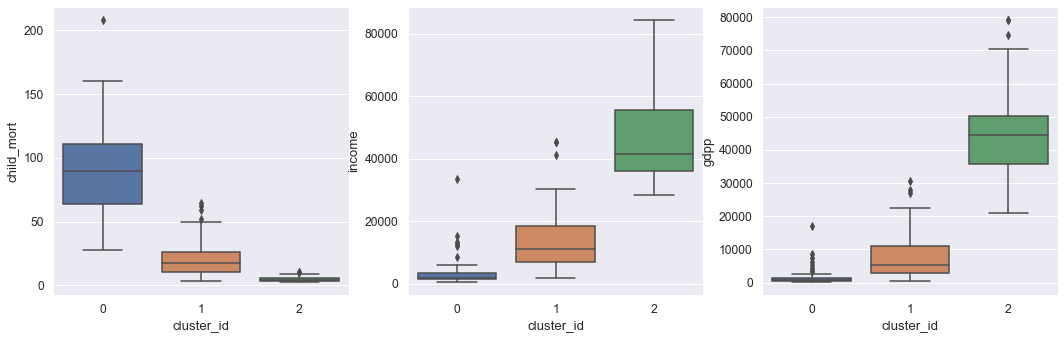

In [1073]:
# Box plot on Original attributes to visualize the spread of the data.
plt.figure(figsize = (18, 18))
feature = ['child_mort', 'income', 'gdpp']
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x='cluster_id', y= i[1], data=df)

Cluster 0 is the most affected cluster as depicted from the boxplots above. As it is the cluster with the highest child_mort, and low income and low gdpp

In [1074]:
# taking out the cluster centres for the clusters created 
df.drop('country',axis=1).groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,10.608604,59.239583,4.992083,1909.208333
1,20.547778,3477.015539,528.894338,3588.133568,13804.333333,7.110944,73.393333,2.242591,7808.577778
2,4.989655,25405.359310,4239.330028,21316.695862,47784.413793,2.876690,80.453103,1.757352,46068.137931


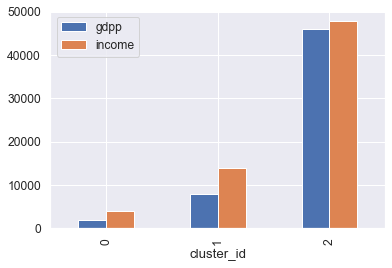

In [1075]:
# Comparision of income and gdpp of all clusters
df[['gdpp', 'income', 'cluster_id']].groupby("cluster_id").mean().plot(kind = 'bar')
plt.show()

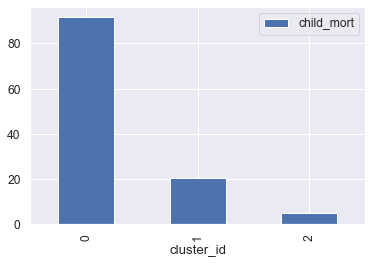

In [1076]:
# Comparision of Child Mortality of all clusters
df[['child_mort', 'cluster_id']].groupby("cluster_id").mean().plot(kind = 'bar')
plt.show()


Picking up the three attributes:: GDPP, Child_mort, Income The needy countries will have low gdpp, high Child_mort and low Income<br>
cluster 0 is having low income and gdp and high child mortality as compared to the other clusters, thus countries with cluster 0 is in the need of aid.

In [1077]:
#deriving the dataframe containing the target cluster sorted acc to the requirement
c0=df[df['cluster_id']==0].sort_values(by = ['child_mort', 'income', 'gdpp'], ascending = [False, True, True])

In [1078]:
c0.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.450,32.1,3.33,662.0,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.200,55.0,5.20,399.0,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.370,59.5,6.55,708.0,0
113,Nigeria,130.0,589.490,118.1310,405.420,5150.0,41.478,60.5,5.84,2330.0,0
112,Niger,123.0,77.256,17.9568,170.868,814.0,2.550,58.8,7.49,348.0,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
37,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609.0,20.800,57.5,6.54,334.0,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0


## Step 8 :Hierarchical Clustering

### Single Linkage

In [1079]:
scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.569622,-0.566958,-0.598741,-0.851668,0.265002,-1.619705,1.903390,-0.702259
1,-0.538993,-0.473858,-0.440393,-0.413584,-0.386946,-0.372075,0.648831,-0.860816,-0.498726
2,-0.272870,-0.424000,-0.486271,-0.476100,-0.221053,1.122161,0.671403,-0.038846,-0.477434
3,2.007831,-0.381249,-0.534088,-0.463973,-0.612045,1.932987,-1.179541,2.128769,-0.530950
4,-0.695682,-0.086742,-0.178410,0.139728,0.125254,-0.764618,0.705262,-0.542634,-0.032042


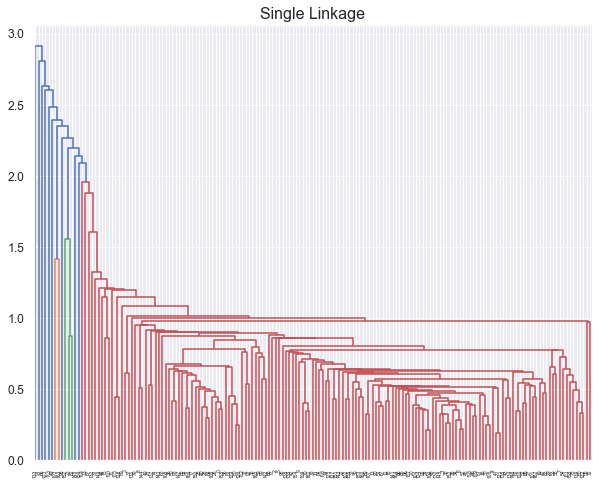

In [1080]:
plt.figure(figsize=(10, 8))
merging=linkage(scaled_df,method='single')
plt.title('Single Linkage', fontsize=16)
dendrogram(merging)
plt.show()

### Complete Linkage

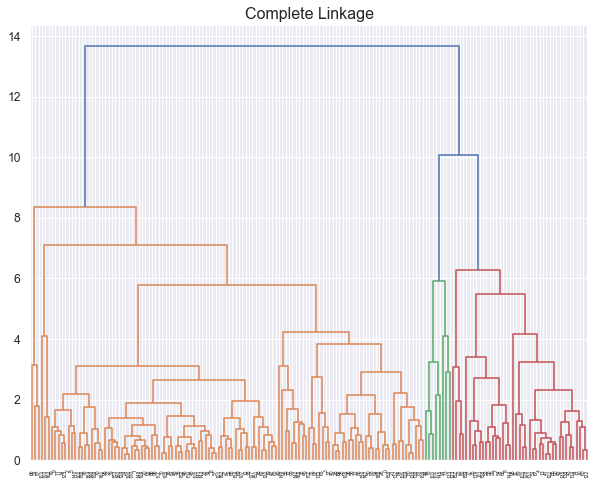

In [1081]:
plt.figure(figsize=(10,8))
merging=linkage(scaled_df,method='complete')
plt.title('Complete Linkage', fontsize=16)
dendrogram(merging)
plt.show()

In [1082]:
# 3 clusters
cluster_labels = cut_tree(merging, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [1083]:
# Create a new datafame with assigning cluster labels to it.
df_h = df.copy()
df_h['cluster_id'] = cluster_labels

df_h.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1


In [1084]:
# checking the value counts of the cluster_id Column
df_h.cluster_id.value_counts()

0    118
1     41
2      8
Name: cluster_id, dtype: int64

## Step 8.1 : Cluster Profiling of clusters formed through Hierarchical Clustering

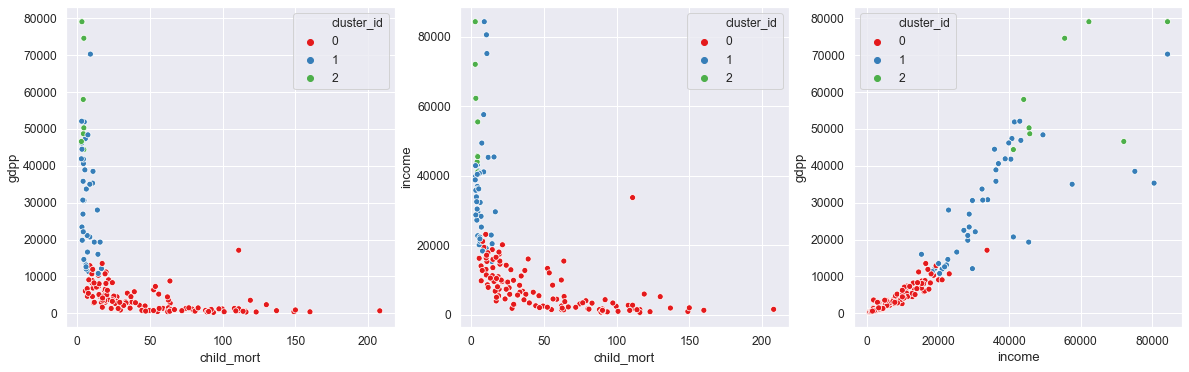

In [1085]:
#scatter plot of the three features child_mort, gdpp and income
plt.figure(figsize=(20,20))
plt.subplot(331)
sns.scatterplot(x = "child_mort" , y = "gdpp", hue = 'cluster_id', data = df_h, palette = "Set1")
plt.subplot(332)
sns.scatterplot(x = "child_mort" , y = "income", hue = 'cluster_id', data = df_h, palette = "Set1")
plt.subplot(333)
sns.scatterplot(x = "income" , y = "gdpp", hue = 'cluster_id', data = df_h, palette = "Set1")
plt.show()

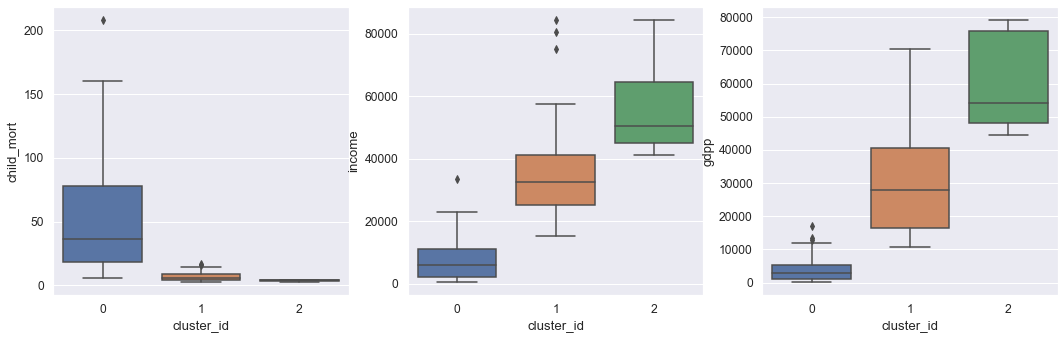

In [1086]:
#boxplot of the three features w.r.t the three clusters
plt.figure(figsize = (18, 18))
feature = ['child_mort', 'income', 'gdpp']
for i in enumerate(feature):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x='cluster_id', y= i[1], data=df_h)

In [1087]:
df_h.drop('country',axis=1).groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,51.512712,1466.113115,238.174789,1582.123747,7581.889831,9.187966,67.125424,3.425508,3732.322034
1,6.882927,13587.873171,2424.054156,11854.251220,35853.024390,3.313976,78.384634,1.812029,29492.682927
2,3.825000,45222.215000,6070.207550,38512.335000,56321.750000,1.571125,80.933750,1.739150,60097.000000


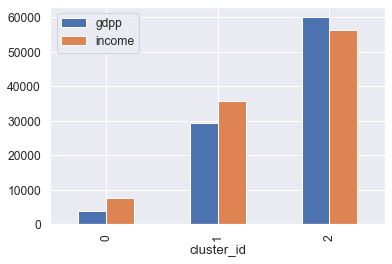

In [1088]:
# Comparision of income and gdpp of all clusters
df_h[['gdpp', 'income', 'cluster_id']].groupby("cluster_id").mean().plot(kind = 'bar')
plt.show()

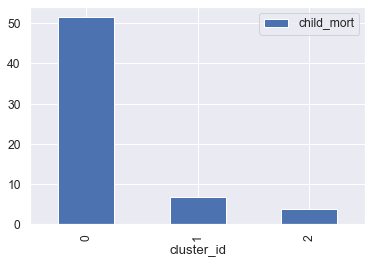

In [1089]:
# Comparision of income and gdpp of all clusters
df_h[['child_mort', 'cluster_id']].groupby("cluster_id").mean().plot(kind = 'bar')
plt.show()

Cluster 0 is the target cluster as it has high child_mort and the low gdpp and income

In [1099]:
#deriving the datafram containing the target cluster sorted acc to the requirement
c0=df_h[df_h['cluster_id']==0].sort_values(by = ['child_mort', 'income', 'gdpp'], ascending = [False, True, True])

In [1100]:
c0.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.450,32.1,3.33,662.0,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.200,55.0,5.20,399.0,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.370,59.5,6.55,708.0,0
113,Nigeria,130.0,589.490,118.1310,405.420,5150.0,41.478,60.5,5.84,2330.0,0
112,Niger,123.0,77.256,17.9568,170.868,814.0,2.550,58.8,7.49,348.0,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
37,"Congo, Dem. Rep.",116.0,137.274,26.4194,165.664,609.0,20.800,57.5,6.54,334.0,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0


### Filtering Based on Socio-Economic Factors

In [1092]:
# Filtering the list by Child Mortality

df_h[df_h['cluster_id'] == 0].sort_values(by=['child_mort'], ascending=[False]).head(7)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.450,32.1,3.33,662.0,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.200,55.0,5.20,399.0,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.370,59.5,6.55,708.0,0
113,Nigeria,130.0,589.490,118.1310,405.420,5150.0,41.478,60.5,5.84,2330.0,0
112,Niger,123.0,77.256,17.9568,170.868,814.0,2.550,58.8,7.49,348.0,0


In [1093]:
# Filtering the List by Income

df_h[df_h['cluster_id'] == 0].sort_values(by=['income'], ascending=[True]).head(7)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0


In [1094]:
# Filtering the List by GDP

df_h[df_h['cluster_id']==0].sort_values(by='gdpp', ascending= True).head(7)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.79,60.8,4.60,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0


## Step 9:Conclusion & Recommendation

After perform the EDA and the K-Means & Hierarchical clustering we can come to the conclusion that follows:-<br>

<ol>
<li>For a countries major development is basically depends on some major factors i.e. Income per capita, GDP, Health infrastructues, Child Mortality etc.</li>
<li>If a country's GDP is low and also per capita Income is low then surely it can say that this particular country is Socio-Economically very week, where as if these two factor for a country is high then this country hold a strong position socio-economically. These are the major two factors that can play a significant role for any country's development</li>
<li>Apart from this if the Child Mortality rate is very high for a ccountry, then it can surely say that in terms of Health infrastructures this country belongs to a non healthy condition.</li>
</ol>

<b>Top Countries which needs help based on K-Means and Hierarchical Clustering methods are:-</b>
<ol>
<li>Haiti</li> 
<li>Sierra Leone</li>
<li>Chad</li>
<li>Central African Republic</li>
<li>Mali</li>
<li>Nigeria</li>
<li>Niger</li>
</ol>